** Machine Learning - Assignment 02

Data Loading

Loading dataset...
Dataset loaded successfully.
Dataset head:
    Invoice ID Branch       City Customer type  Gender  \
0  750-67-8428   Alex     Yangon        Member  Female   
1  226-31-3081   Giza  Naypyitaw        Normal  Female   
2  631-41-3108   Alex     Yangon        Normal  Female   
3  123-19-1176   Alex     Yangon        Member  Female   
4  373-73-7910   Alex     Yangon        Member  Female   

             Product line  Unit price  Quantity   Tax 5%     Sales       Date  \
0       Health and beauty       74.69         7  26.1415  548.9715   1/5/2019   
1  Electronic accessories       15.28         5   3.8200   80.2200   3/8/2019   
2      Home and lifestyle       46.33         7  16.2155  340.5255   3/3/2019   
3       Health and beauty       58.22         8  23.2880  489.0480  1/27/2019   
4       Sports and travel       86.31         7  30.2085  634.3785   2/8/2019   

          Time      Payment    cogs  gross margin percentage  gross income  \
0   1:08:00 PM      Ewal

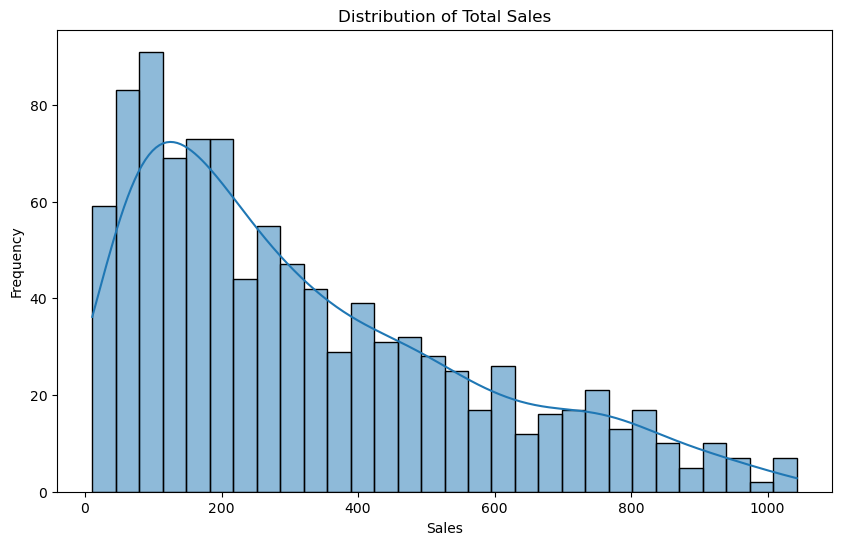


Learned Q-table:
       Decrease Price  Increase Price
10.08        0.000000        0.000000
10.13        0.000000        0.000000
10.16        0.000000        0.000000
10.17        0.000000        0.000000
10.18        0.000000        0.000000
...               ...             ...
99.82        0.000000        0.000000
99.83        0.000000        0.000000
99.89        0.000000        0.000000
99.92        0.000000        0.000000
99.96      153.545175      175.116396

[943 rows x 2 columns]

Best Actions for Each Price Level (Condensed View):
    Price     Best Action
0   10.08  Decrease Price
1   10.13  Decrease Price
2   10.16  Decrease Price
3   10.17  Decrease Price
4   10.18  Decrease Price
5   10.53  Decrease Price
6   10.56  Decrease Price
7   10.59  Decrease Price
8   10.69  Decrease Price
9   10.75  Decrease Price
10  10.96  Decrease Price
11  10.99  Decrease Price
12  11.28  Decrease Price
13  11.43  Decrease Price
14  11.53  Decrease Price
15  11.81  Decrease Price
16  11.

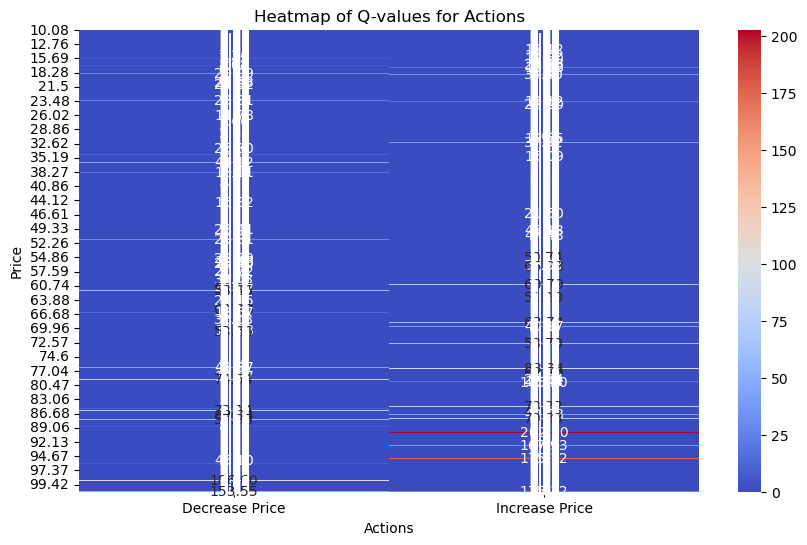

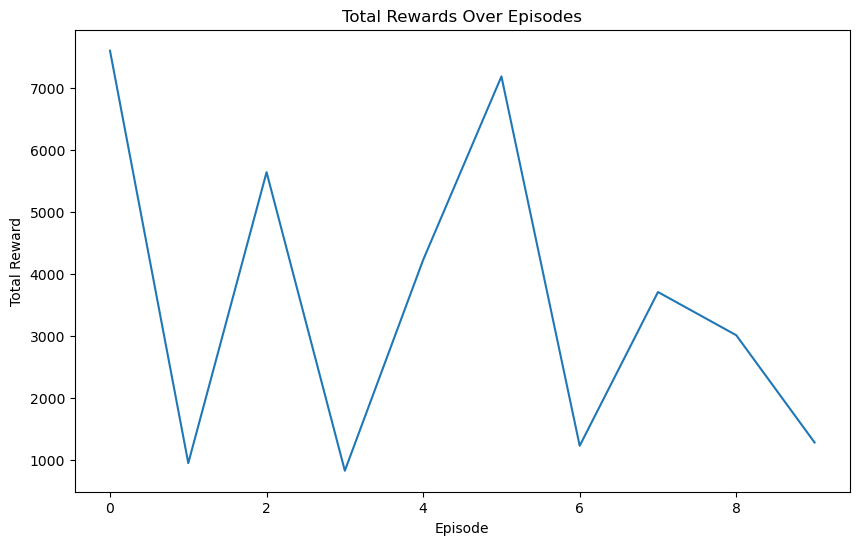

In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset with error handling
try:
    print("Loading dataset...")
    data = pd.read_csv("C:\\Users\\nirsh\\MS23002456\\Reinforcement_SuperMarket_Analysis.csv", low_memory=False, nrows=1000)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: Dataset file not found. Please check the file path.")
    data = pd.DataFrame()  # Empty DataFrame if file load fails

# Check if data was loaded correctly
if not data.empty:
    # Preview the dataset
    print("Dataset head:")
    print(data.head())
    print("\nDataset columns:")
    print(data.columns)
else:
    print("Dataset is empty or failed to load.")

# Create a Total_Sales column if it doesn't exist
if 'Total_Sales' not in data.columns:
    if 'Sales' in data.columns:
        data['Total_Sales'] = data['Sales']
    else:
        print("Error: 'Sales' column not found in the dataset. Cannot create 'Total_Sales' column.")

# Visualize the sales distribution if 'Sales' column exists
if 'Sales' in data.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data['Sales'], bins=30, kde=True)
    plt.title('Distribution of Total Sales')
    plt.xlabel('Sales')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("Error: 'Sales' column not found, skipping sales distribution visualization.")

# Check for the correct column name for price
price_column = 'Unit price'
if price_column not in data.columns:
    raise KeyError(f"{price_column} column does not exist in the dataset.")

# Define the Supermarket Environment
class SupermarketEnv:
    def __init__(self, data):
        self.data = data
        self.state_space = np.sort(data[price_column].unique())
        self.action_space = [0, 1]  # 0: decrease price, 1: increase price
        self.current_state = None

    def reset(self):
        self.current_state = random.choice(self.state_space)
        return self.current_state

    def step(self, action):
        # Define new price based on action
        if action == 0:  # Decrease price by 10%
            new_price = self.current_state * 0.9
        else:            # Increase price by 10%
            new_price = self.current_state * 1.1

        # Get the closest price in the dataset
        new_price = self.get_closest_price(new_price)
        sales_data = self.data[self.data[price_column] == new_price]

        # Calculate reward
        reward = sales_data['Total_Sales'].sum() if not sales_data.empty else 0
        self.current_state = new_price
        return new_price, reward

    def get_closest_price(self, price):
        # Find the closest price to the current price in the state space
        idx = np.searchsorted(self.state_space, price)
        if idx == len(self.state_space):
            return self.state_space[-1]
        elif idx > 0 and (price - self.state_space[idx - 1]) < (self.state_space[idx] - price):
            return self.state_space[idx - 1]
        else:
            return self.state_space[idx]

# Initialize the environment
env = SupermarketEnv(data)

# Q-learning parameters
q_table = np.zeros((len(env.state_space), len(env.action_space)))
learning_rate = 0.1
discount_factor = 0.95
exploration_rate = 1.0
exploration_decay = 0.99
num_episodes = 10
rewards = []

# Q-learning algorithm
for episode in range(num_episodes):
    state = env.reset()
    state_index = np.where(env.state_space == state)[0][0]
    total_reward = 0

    for _ in range(10):
        # Select action based on exploration-exploitation trade-off
        if random.uniform(0, 1) < exploration_rate:
            action = random.choice(env.action_space)
        else:
            action = np.argmax(q_table[state_index])

        new_state, reward = env.step(action)
        new_state_index = np.where(env.state_space == new_state)[0][0]

        # Update Q-table
        q_table[state_index, action] += learning_rate * (
            reward + discount_factor * np.max(q_table[new_state_index]) - q_table[state_index, action]
        )

        total_reward += reward
        state_index = new_state_index

    rewards.append(total_reward)
    exploration_rate *= exploration_decay

# Display the learned Q-table as a DataFrame
q_values_df = pd.DataFrame(q_table, index=env.state_space, columns=['Decrease Price', 'Increase Price'])
print("\nLearned Q-table:")
print(q_values_df)

# Find the best action for each state
best_actions = np.argmax(q_table, axis=1)

# Display the best actions for each price level as a condensed DataFrame
best_actions_df = pd.DataFrame({
    'Price': env.state_space,
    'Best Action': ["Decrease Price" if action == 0 else "Increase Price" for action in best_actions]
})

# Show a subset of the best actions
print("\nBest Actions for Each Price Level (Condensed View):")
print(best_actions_df.head(20))  # Display only the first 20 rows for brevity

# Visualize Q-values for actions as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(q_values_df, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of Q-values for Actions')
plt.xlabel('Actions')
plt.ylabel('Price')
plt.show()

# Plot total rewards over episodes
plt.figure(figsize=(10, 6))
plt.plot(rewards)
plt.title('Total Rewards Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()
